# Data Loading

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np 


# Specify the path to your dataset
path = r"..\Data"
data = []
labels = []

# Function to extract audio samples and labels
def extract_audio_sample(data,labels,path):
    # List all the folders in the dataset path
    speakers = os.listdir(path)

    for i, speaker in enumerate(speakers):
        # List all audio files for the speaker
        files = glob.glob(os.path.join(path, speaker, "*.wav"))

       # Append data and labels to train and test
        data.extend(files)
        labels.extend([speaker] * len(files))

    return data, labels

data,labels = extract_audio_sample(data,labels,path)

#Dictionary labels to integers
label2int = {k: v for v, k in enumerate(set(labels))}
#Reverse Dictionary Integers to Labels
int2label = {v: k for k, v in label2int.items()}
#Convert labels to integers
labels = [label2int[i] for i in labels]

# Embedding

In [2]:
#Import the pyannote model acheiving state-oft-the-art results in speaker embedding for speaker verification due to its X-Vector and SincNet fusion architecture
from pyannote.audio import Model
pipeline = Model.from_pretrained("pyannote/embedding",use_auth_token="")

c:\Users\noahg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\noahg\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyannote\audio\core\io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
c:\Users\noahg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_audiomentations\utils\io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
pytorch_model.bin: 100%|██████████| 96.4M/96.4M [01:18<00:00, 1.23MB/s]
config.yaml: 100%|██████████| 2.00k/2.

Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.2+cpu. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.2+cpu. Bad things might happen unless you revert torch to 1.x.


In [3]:
from pyannote.audio import Inference

inference = Inference(pipeline, window="whole")

dataset = []
#Extract embeddings for each audio file
for i in range(len(data)):
    embedding = inference(data[i])
    dataset.append(embedding)

# Classification

In [4]:
#Create a tensorflow cnn model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Assuming that `data` is your dataset and `labels` are your target labels
train_data, test_data, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.25, random_state=42)

#clear session
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(512,1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(18, activation='softmax'))


best_model = tf.keras.callbacks.ModelCheckpoint(
    'best_model_1.h5',
    monitor='val_loss', # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)


model.compile(optimizer="adam",
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])

train_features = np.array(train_data)
train_labels = np.array(train_labels)
test_features = np.array(test_data)
test_labels = np.array(test_labels)

model.fit(train_features, train_labels, validation_data=(test_features,test_labels),epochs=10, batch_size=32,callbacks=[best_model])


Epoch 1/10
104/108 [===========================>..] - ETA: 0s - loss: 3.6454 - sparse_categorical_accuracy: 0.6070
Epoch 1: val_loss improved from inf to 0.02928, saving model to best_model_1.h5
108/108 [==============================] - 3s 18ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.0293 - val_sparse_categorical_accuracy: 0.9974
Epoch 2/10
106/108 [============================>.] - ETA: 0s - loss: 0.1046 - sparse_categorical_accuracy: 0.9696
Epoch 2: val_loss improved from 0.02928 to 0.01499, saving model to best_model_1.h5
108/108 [==============================] - 2s 17ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.0150 - val_sparse_categorical_accuracy: 0.9983
Epoch 3/10
105/108 [============================>.] - ETA: 0s - loss: 0.0363 - sparse_categorical_accuracy: 0.9923
Epoch 3: val_loss did not improve from 0.01499
108/108 [==============================] - 2s 19ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.

In [18]:
#check that the data in train_data and test_data are different
print(train_data[0])
print(test_data[0])





[-4.59249001e+01 -5.68878212e+01  4.31795578e+01 -6.56249952e+00
  1.69349422e+01 -1.68847866e+01 -1.56158876e+00 -6.18296814e+01
 -1.69257224e+00 -1.08318691e+01  1.70797138e+01 -5.15545540e+01
 -4.84236717e+01  2.68198986e+01  5.83148289e+00 -2.74413757e+01
 -8.78753090e+00  2.17722607e+01  3.60123100e+01  5.42533150e+01
  8.82842731e+00  1.38502159e+01 -7.82237530e+00  1.23844604e+01
  2.00127258e+01 -1.63406734e+01  8.29967651e+01 -4.86727536e-01
 -9.50809956e+00  3.72503781e+00  4.95638618e+01 -1.79915886e+01
  4.34341583e+01  2.95172234e+01  8.02114868e+01  6.65265121e+01
  4.55714073e+01  1.39470816e+01 -6.57091904e+01  2.01658783e+01
 -4.04447403e+01 -3.38343191e+00  2.93256626e+01 -2.34526844e+01
 -5.43544769e+01  2.01196651e+01  1.03618851e+02 -1.36589212e+01
  2.40681028e+00  3.98110275e+01  1.00860001e+02  2.11593323e+01
  2.19500790e+01  4.58814201e+01 -2.46301727e+01  2.01693497e+01
  5.67123604e+01  2.04810524e+01 -3.73596535e+01 -1.06393633e+01
 -1.67241020e+01 -5.06829

In [ ]:
# Show me the validation accuracy, precision, recall, and F1 score

from sklearn.metrics import classification_report
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

36/36 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        23
           2       1.00      0.99      0.99        85
           3       1.00      1.00      1.00        67
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        45
           7       1.00      1.00      1.00        86
           8       1.00      1.00      1.00        70
           9       0.99      0.99      0.99       147
          10       1.00      1.00      1.00        74
          11       0.98      1.00      0.99        44
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00        83
          15       1.00      1.00      1.00        34
          16       1.00     

1147

# Plots

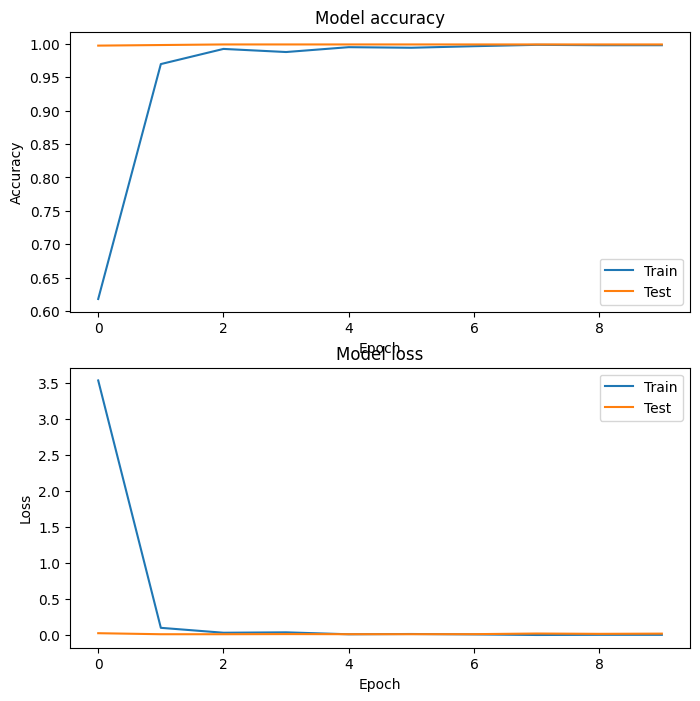

In [5]:
#plot the loss and accuracy curves for training and validation
import matplotlib.pyplot as plt
history = model.history
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

# Confusion Matrix

36/36 [==============================] - 0s 5ms/step


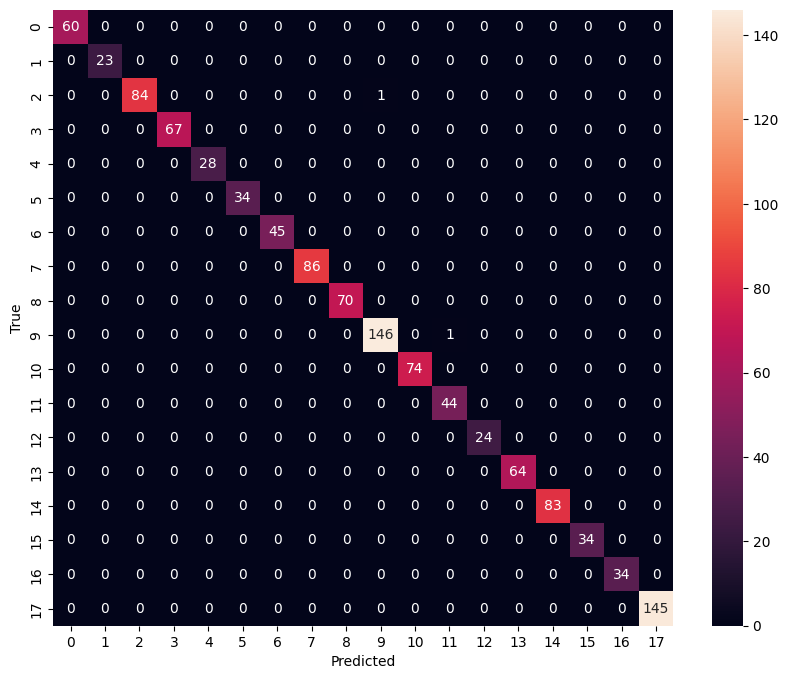

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = tf.keras.models.load_model(r'best_model_1.h5')
for data in test_data:
    data = data.reshape(1,512,1)
y_pred = model.predict(np.stack(test_data))
y_pred = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(test_labels, y_pred) 
labels = np.unique(np.concatenate([test_labels, y_pred]))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### Notebook réalisé par Noah Goulin